In [1]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

In [2]:
# Initialize Spark session
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
24/10/04 16:13:20 WARN Utils: Your hostname, AATLaptop resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/10/04 16:13:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/04 16:13:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/04 16:13:21 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# Read the Parquet file into a Spark DataFrame
sdf = spark.read.parquet("../data/curated/prop_data_cleaned2.parquet")
sdf.printSchema()   

root
 |-- postal_code: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- property_url: string (nullable = true)
 |-- beds: integer (nullable = true)
 |-- baths: integer (nullable = true)
 |-- parkings: integer (nullable = true)
 |-- cost: integer (nullable = true)
 |-- built_in_wardrobes: integer (nullable = true)
 |-- dishwasher: integer (nullable = true)
 |-- air_conditioning: integer (nullable = true)
 |-- floorboards: integer (nullable = true)
 |-- secure_parking: integer (nullable = true)
 |-- intercom: integer (nullable = true)
 |-- heating: integer (nullable = true)
 |-- ensuite: integer (nullable = true)
 |-- balcony_deck: integer (nullable = true)
 |-- gym: integer (nullable = true)
 |-- furnished: integer (nullable = true)
 |-- close_to_shops: integer (nullable = true)
 |-- close_to_transport: integer (nullable = true)
 |-- fully_fenced: integer (nullable = true)
 |-- close_to_schools: integer (nullable = true)
 |-- ducted_heating: integer (nullable = true)
 

### Read in csv file and join them here (For now)

In [4]:

sdf.show()

24/10/04 16:13:30 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------+--------------------+--------------------+----+-----+--------+----+------------------+----------+----------------+-----------+--------------+--------+-------+-------+------------+---+---------+--------------+------------------+------------+----------------+--------------+--------------------+-------------+-------------+-------+-----+----------------+------------+----------------+------------+---------------+-----------+--------------------------------+-----------------------------------+---------------------------+-------------+----------------------------------+-------------------------------------+-----------------------------+------------------+---------------------------------------+------------------------------------------+----------------------------------+---------------+------------------------------------+---------------------------------------+-------------------------------+------------------------+---------------------------------------------+-----------------

In [5]:
def shape(sdf: DataFrame) -> None:
    """
    Returns the shape of a Spark DataFrame as a tuple (number of rows, number of columns).
    """
    num_rows = sdf.count()
    num_columns = len(sdf.columns)
    print(f"Shape of the DataFrame: {num_rows} rows, {num_columns} columns.")

shape(sdf)

Shape of the DataFrame: 810 rows, 63 columns.


In [6]:
sdf.columns

['postal_code',
 'name',
 'property_url',
 'beds',
 'baths',
 'parkings',
 'cost',
 'built_in_wardrobes',
 'dishwasher',
 'air_conditioning',
 'floorboards',
 'secure_parking',
 'intercom',
 'heating',
 'ensuite',
 'balcony_deck',
 'gym',
 'furnished',
 'close_to_shops',
 'close_to_transport',
 'fully_fenced',
 'close_to_schools',
 'ducted_heating',
 'split_system_heating',
 'swimming_pool',
 'remote_garage',
 'balcony',
 'study',
 'garden_courtyard',
 'pets_allowed',
 'internal_laundry',
 'alarm_system',
 'prop_type_index',
 'parks_count',
 'parks_Average Travel Time (Mins)',
 'parks_Average Travel Distance (Kms)',
 'parks_Time_Distance_Product',
 'schools_count',
 'schools_Average Travel Time (Mins)',
 'schools_Average Travel Distance (Kms)',
 'schools_Time_Distance_Product',
 'supermarkets_count',
 'supermarkets_Average Travel Time (Mins)',
 'supermarkets_Average Travel Distance (Kms)',
 'supermarkets_Time_Distance_Product',
 'hospitals_count',
 'hospitals_Average Travel Time (Mins)

In [10]:
# Select relevant features for the model
# feature_columns = [
#  'beds',
#  'baths',
#  'parkings',
#  'postal_code',
# #  'built_in_wardrobes',
# #  'dishwasher',
# #  'air_conditioning',
# #  'floorboards',
# #  'secure_parking',
# #  'intercom',
# #  'heating',
# #  'ensuite',
# #  'balcony_deck',
# #  'gym',
# #  'furnished',
# #  'close_to_shops',
# #  'close_to_transport',
# #  'fully_fenced',
# #  'close_to_schools',
# #  'ducted_heating',
# #  'split_system_heating',
# #  'swimming_pool',
# #  'remote_garage',
# #  'balcony',
# #  'study',
# #  'garden_courtyard',
# #  'pets_allowed',
# #  'internal_laundry',
# #  'alarm_system',
#  'prop_type_index', 
#  'median_inc', 
#  '2023_pop',
#  'pop_percentage_increase']
# #  'parks',
# #  'schools',
# #  'supermarkets',
# #  'hospitals',
# #  'shopping_districts',
# #  'CBD',
# #  'train_stations']


feature_columns = [
    "postal_code",
    "beds",
    "baths",
    "parkings",
    "built_in_wardrobes",
    "dishwasher",
    "air_conditioning",
    "floorboards",
    "secure_parking",
    "intercom",
    "heating",
    "ensuite",
    "balcony_deck",
    "gym",
    "furnished",
    "close_to_shops",
    "close_to_transport",
    "fully_fenced",
    "close_to_schools",
    "ducted_heating",
    "split_system_heating",
    "swimming_pool",
    "remote_garage",
    "balcony",
    "study",
    "garden_courtyard",
    "pets_allowed",
    "internal_laundry",
    "alarm_system",
    "prop_type_index",
    "parks_count",
    "parks_Average Travel Time (Mins)",
    "parks_Average Travel Distance (Kms)",
    "parks_Time_Distance_Product",
    "schools_count",
    "schools_Average Travel Time (Mins)",
    "schools_Average Travel Distance (Kms)",
    "schools_Time_Distance_Product",
    "supermarkets_count",
    "supermarkets_Average Travel Time (Mins)",
    "supermarkets_Average Travel Distance (Kms)",
    "supermarkets_Time_Distance_Product",
    "hospitals_count",
    "hospitals_Average Travel Time (Mins)",
    "hospitals_Average Travel Distance (Kms)",
    "hospitals_Time_Distance_Product",
    "shopping_districts_count",
    "shopping_districts_Average Travel Time (Mins)",
    "shopping_districts_Average Travel Distance (Kms)",
    "shopping_districts_Time_Distance_Product",
    "CBD_Average Travel Distance (Kms)",
    "train_stations_count",
    "train_stations_Average Travel Time (Mins)",
    "train_stations_Average Travel Distance (Kms)",
    "train_stations_Time_Distance_Product",
    "median_inc",
    "2022_pop",
    "2023_pop",
    "pop_percentage_increase",
    "normalized_livability_score"
]

In [10]:
# feature_columns = [
#     'beds', 'baths', 'parkings', 'prop_type_index',
#     'parks', 'schools', 'supermarkets', 'hospitals', 'shopping_districts', 'CBD', 'train_stations'
# ]

In [11]:
# Create a VectorAssembler to combine feature columns into a single vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Transform the features into a single vector column
data = sdf.select('cost', *feature_columns)

data = assembler.transform(data)

data

cost,postal_code,beds,baths,parkings,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system,prop_type_index,parks_count,parks_Average Travel Time (Mins),parks_Average Travel Distance (Kms),parks_Time_Distance_Product,schools_count,schools_Average Travel Time (Mins),schools_Average Travel Distance (Kms),schools_Time_Distance_Product,supermarkets_count,supermarkets_Average Travel Time (Mins),supermarkets_Average Travel Distance (Kms),supermarkets_Time_Distance_Product,hospitals_count,hospitals_Average Travel Time (Mins),hospitals_Average Travel Distance (Kms),hospitals_Time_Distance_Product,shopping_districts_count,shopping_districts_Average Travel Time (Mins),shopping_districts_Average Travel Distance (Kms),shopping_districts_Time_Distance_Product,CBD_Average Travel Distance (Kms),train_stations_count,train_stations_Average Travel Time (Mins),train_stations_Average Travel Distance (Kms),train_stations_Time_Distance_Product,median_inc,2022_pop,2023_pop,pop_percentage_increase,normalized_livability_score,features
800,3000,2,2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,17,3.296666666666667,1.4133333333333333,4.659288888888889,3,2.453333333333333,1.0333333333333334,2.535111111111111,17,2.4400000000000004,1.088125,2.6550250000000006,0,5.69,1.8766666666666667,10.5265,9,2.8579999999999997,1.198,3.4238839999999993,1.28,3,3.23,1.5,4.845,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387,88,"(60,[0,1,2,3,14,3..."
760,3000,2,1,1,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0.0,0,12.12,9.48,114.8976,6,10.231666666666667,9.791666666666666,100.18506944444445,23,1.8191304347826083,0.7408695652173912,1.3477383742911149,0,5.69,1.8766666666666667,10.5265,10,2.2620000000000005,0.8379999999999999,1.895556,0.61,0,11.6,8.68,100.68799999999999,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387,62,"[3000.0,2.0,1.0,1..."
550,3000,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,12.12,9.48,114.8976,6,10.648333333333335,9.886666666666667,105.27652222222224,28,2.386428571428571,0.9214285714285716,2.198923469387755,0,5.69,1.8766666666666667,10.5265,11,2.375,0.8566666666666666,2.034583333333333,0.48,4,5.265000000000001,2.2199999999999998,11.6883,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387,86,"(60,[0,1,2,3,31,3..."
525,3000,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0,23,3.16,1.3566666666666667,4.287066666666667,2,3.605,1.585,5.713925,17,3.1187500000000004,1.279375,3.9900507812500003,0,5.69,1.8766666666666667,10.5265,7,4.046,1.526,6.174196,1.88,3,4.675,1.83,8.55525,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387,84,"(60,[0,1,2,3,8,9,..."
475,3000,1,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,12.12,9.48,114.8976,1,3.98,1.61,6.4078,18,3.4033333333333333,1.29,4.3903,4,4.613333333333333,1.8766666666666667,8.657688888888888,9,2.895,1.105,3.198975,0.99,3,2.37,0.89,2.1093,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387,68,"(60,[0,1,2,3,4,5,..."
475,3000,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,12.12,9.48,114.8976,2,2.795,1.17,3.2701499999999997,28,2.4188888888888895,0.9892592592592592,2.3929082304526754,0,5.69,1.8766666666666667,10.5265,11,1.956,0.776,1.517856,0.39,4,4.3549999999999995,1.81,7.882549999999999,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387,76,"(60,[0,1,2,3,31,3..."
450,3000,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,12.12,9.48,114.8976,4,3.4325,1.3875,4.76259375,28,2.0829629629629625,0.8637037037037035,1.7990628257887509,0,5.69,1.8766666666666667,10.5265,12,1.9316666666666666,0.775,1.4970416666666666,0.41,4,4.545,2.04,9.2718

In [12]:
# Create a StandardScaler instance
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withMean=True, withStd=True)

# Fit the scaler to the data
scaler_model = scaler.fit(data)

# Transform the data using the fitted scaler
data = scaler_model.transform(data)

data = data.filter(F.col("cost") > 100)

In [13]:
# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed = 12)
train_data

cost,postal_code,beds,baths,parkings,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system,prop_type_index,parks_count,parks_Average Travel Time (Mins),parks_Average Travel Distance (Kms),parks_Time_Distance_Product,schools_count,schools_Average Travel Time (Mins),schools_Average Travel Distance (Kms),schools_Time_Distance_Product,supermarkets_count,supermarkets_Average Travel Time (Mins),supermarkets_Average Travel Distance (Kms),supermarkets_Time_Distance_Product,hospitals_count,hospitals_Average Travel Time (Mins),hospitals_Average Travel Distance (Kms),hospitals_Time_Distance_Product,shopping_districts_count,shopping_districts_Average Travel Time (Mins),shopping_districts_Average Travel Distance (Kms),shopping_districts_Time_Distance_Product,CBD_Average Travel Distance (Kms),train_stations_count,train_stations_Average Travel Time (Mins),train_stations_Average Travel Distance (Kms),train_stations_Time_Distance_Product,median_inc,2022_pop,2023_pop,pop_percentage_increase,normalized_livability_score,features,scaled_features
150,3000,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,12.12,9.48,114.8976,3,4.003333333333333,1.4266666666666667,5.711422222222222,21,2.2266666666666666,0.8452380952380955,1.8820634920634924,5,3.4675,1.3375,4.63778125,10,2.376,0.9800000000000001,2.3284800000000003,0.98,4,3.14,1.33,4.176200000000001,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387,82,"(60,[0,1,2,3,29,3...",[-0.9146431421007...
260,3006,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,32,2.335,0.855,1.996425,3,2.73,1.25,3.4125,11,2.1536363636363633,0.8154545454545455,1.756192561983471,0,5.69,1.8766666666666667,10.5265,3,2.775,1.2349999999999999,3.4271249999999998,2.62,1,5.66,2.04,11.5464,59122.74113230943,11310.741798439643,12222.066355277488,8.057159937675925,71,"(60,[0,1,2,3,30,3...",[1.43232922886677...
261,3000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,12.12,9.48,114.8976,6,10.263333333333334,9.781666666666668,100.39250555555557,23,1.9108695652173915,0.77,1.4713695652173915,4,3.61,1.4224999999999999,5.135224999999999,10,1.7133333333333332,0.7066666666666667,1.2107555555555554,0.79,0,11.6,8.68,100.68799999999999,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387,67,"(60,[0,3,29,31,32...",[-0.9146431421007...
300,3000,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,12.12,9.48,114.8976,3,2.61,1.0,2.61,20,2.748947368421053,1.037894736842105,2.853118005540166,0,5.69,1.8766666666666667,10.5265,10,2.96,1.15,3.404,1.37,0,11.6,8.68,100.68799999999999,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387,54,"(60,[0,1,2,3,31,3...",[-0.9146431421007...
330,3000,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,23,3.2866666666666666,1.3366666666666667,4.393177777777778,2,3.305,1.48,4.8914,17,2.733125,1.1437500000000003,3.1260117187500005,0,5.69,1.8766666666666667,10.5265,7,3.44,1.3439999999999999,4.623359999999999,1.5,3,4.335,1.725,7.477875,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387,84,"(60,[0,2,3,14,30,...",[-0.9146431421007...
340,3002,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,12.12,9.48,114.8976,0,35.0,21.79,762.65,0,11.944285714285714,9.01142857142857,107.6350775510204,8,2.8,1.195,3.346,0,8.08,4.273333333333333,34.528533333333336,2.21,3,3.08,1.4,4.311999999999999,81648.0,4889.0,5100.0,4.315811004295357,1,"(60,[0,1,2,3,31,3...",[-0.1323190184449...
350,3000,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,12.12,9.48,114.8976,4,3.2074999999999996,1.26,4.041449999999999,27,2.3826923076923077,0.9769230769230768,2.3277071005917156,0,5.69,1.8766666666666667,10.5265,12,2.27,0.9466

In [14]:
# Initialize the Linear Regression model
lr = LinearRegression(featuresCol='scaled_features', labelCol='cost')

# Fit the model to the training data
lr_model = lr.fit(train_data)

24/10/04 16:16:35 WARN Instrumentation: [759f55b4] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:16:35 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/10/04 16:16:35 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
24/10/04 16:16:35 WARN Instrumentation: [759f55b4] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [15]:
# Print model summary
print("Intercept: " + str(lr_model.intercept))
print("RMSE: " + str(lr_model.summary.rootMeanSquaredError))
print("r2: " + str(lr_model.summary.r2))

# Get the coefficients and feature names
coefficients = lr_model.coefficients.toArray()
feature_names = feature_columns

# Create a DataFrame from the coefficients and feature names
coefficients_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

# Sort the DataFrame by the 'coefficient' column in decreasing order
coefficients_df = coefficients_df.sort_values(by='coefficient', ascending=False)

# Evaluate the model on the test data
test_results = lr_model.evaluate(test_data)

# Print evaluation metrics
print("Test RMSE: ", test_results.rootMeanSquaredError)
print("Test r2: ", test_results.r2)

coefficients_df

Intercept: 609.7462023725649
RMSE: 59.87625433233332
r2: 0.7062581375280064
Test RMSE:  72.54571173681784
Test r2:  0.5566661854051178


,feature,coefficient
49,shopping_districts_Time_Distance_Product,79.403981
47,shopping_districts_Average Travel Time (Mins),71.346672
1,beds,66.723897
54,train_stations_Time_Distance_Product,48.532318
43,hospitals_Average Travel Time (Mins),45.366022
59,normalized_livability_score,35.564880
2,baths,34.297261
36,schools_Average Travel Distance (Kms),32.666197
53,train_stations_Average Travel Distance (Kms),21.333360
31,parks_Average Travel Time (Mins),17.794913


In [16]:
# Initialize the Lasso Regression model
lasso = LinearRegression(featuresCol='features', labelCol='cost', elasticNetParam=0.5, regParam=0.1)

# Fit the model to the data
lasso_model = lasso.fit(train_data)

In [17]:
# Print model summary
print("Intercept: " + str(lasso_model.intercept))
print("RMSE: " + str(lasso_model.summary.rootMeanSquaredError))
print("r2: " + str(lasso_model.summary.r2))

# Get the coefficients and feature names
lasso_coefficients = lasso_model.coefficients.toArray()

# Create a DataFrame from the coefficients and feature names
lasso_coefficients_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': lasso_coefficients
})

# Sort the DataFrame by the 'coefficient' column in decreasing order
lasso_coefficients_df = lasso_coefficients_df.sort_values(by='coefficient', ascending=False)

# Evaluate the model on the test data
lasso_test_results = lasso_model.evaluate(test_data)

# Print evaluation metrics
print("Lasso Test RMSE: ", lasso_test_results.rootMeanSquaredError)
print("Lasso Test r2: ", lasso_test_results.r2)

lasso_coefficients_df

Intercept: 11788.223448696905
RMSE: 60.415480975974354
r2: 0.7009436214139482
Lasso Test RMSE:  71.5856599940147
Lasso Test r2:  0.5683224803006864


,feature,coefficient
1,beds,110.664150
2,baths,75.598418
25,garden_courtyard,66.487912
19,ducted_heating,63.393122
26,pets_allowed,43.601986
14,furnished,40.233281
3,parkings,39.612571
13,gym,29.791060
7,floorboards,24.983748
24,study,23.793019


In [18]:
def backward_elimination(data: DataFrame, features: list, label: str, stop_threshold=0.1):
    features_to_keep = features.copy()
    
    while len(features_to_keep) > 0:
        print(f"Training model with {len(features_to_keep)} features.")
        
        # Assemble the feature vector for the current set of features
        assembler = VectorAssembler(inputCols=features_to_keep, outputCol="features")
        
        # Drop the existing 'features' column if it exists
        if 'features' in data.columns:
            data = data.drop('features')

        # Transform the data to create the new 'features' column
        data_assembled = assembler.transform(data).select("features", label)
        
        # Create a StandardScaler instance
        scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withMean=True, withStd=True)
        
        # Fit the scaler to the data and transform it
        scaler_model = scaler.fit(data_assembled)
        data_scaled = scaler_model.transform(data_assembled)
        
        # Train the model on the scaled features
        lr = LinearRegression(featuresCol="scaled_features", labelCol=label)
        lr_model = lr.fit(data_scaled)
        
        # Get the coefficients and associated features
        coefficients = lr_model.coefficients
        coef_feature_pairs = list(zip(coefficients, features_to_keep))
        
        # Find the least significant feature (smallest coefficient magnitude)
        least_significant_feature = min(coef_feature_pairs, key=lambda x: abs(x[0]))[1]
        
        # Check the magnitude of the smallest coefficient using absolute value
        if abs(min(coef_feature_pairs, key=lambda x: abs(x[0]))[0]) < stop_threshold:
            print(f"Removing least significant feature: {least_significant_feature}")
            features_to_keep.remove(least_significant_feature)
        else:
            break
    
    print(f"Final set of features: {features_to_keep}")
    return features_to_keep


In [19]:
# Perform backward elimination
final_features = backward_elimination(data, feature_columns, 'cost', stop_threshold=8.5)

Training model with 60 features.


24/10/04 16:16:53 WARN Instrumentation: [0642c3d6] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:16:53 WARN Instrumentation: [0642c3d6] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: remote_garage
Training model with 59 features.


24/10/04 16:16:53 WARN Instrumentation: [580e5d48] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:16:53 WARN Instrumentation: [580e5d48] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: CBD_Average Travel Distance (Kms)
Training model with 58 features.


24/10/04 16:16:54 WARN Instrumentation: [b8887c55] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:16:54 WARN Instrumentation: [b8887c55] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: hospitals_Average Travel Distance (Kms)
Training model with 57 features.


24/10/04 16:16:55 WARN Instrumentation: [059e49cb] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:16:55 WARN Instrumentation: [059e49cb] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: heating
Training model with 56 features.


24/10/04 16:16:55 WARN Instrumentation: [29a435fd] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:16:55 WARN Instrumentation: [29a435fd] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: supermarkets_Average Travel Time (Mins)
Training model with 55 features.


24/10/04 16:16:56 WARN Instrumentation: [69ff09f5] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:16:56 WARN Instrumentation: [69ff09f5] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: air_conditioning
Training model with 54 features.


24/10/04 16:16:56 WARN Instrumentation: [6131d6b2] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:16:56 WARN Instrumentation: [6131d6b2] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: built_in_wardrobes
Training model with 53 features.


24/10/04 16:16:57 WARN Instrumentation: [71616010] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:16:57 WARN Instrumentation: [71616010] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: internal_laundry
Training model with 52 features.


24/10/04 16:16:57 WARN Instrumentation: [eacb06f6] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:16:57 WARN Instrumentation: [eacb06f6] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: split_system_heating
Training model with 51 features.


24/10/04 16:16:58 WARN Instrumentation: [857b3802] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:16:58 WARN Instrumentation: [857b3802] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: dishwasher
Training model with 50 features.


24/10/04 16:16:58 WARN Instrumentation: [c308c14c] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:16:58 WARN Instrumentation: [c308c14c] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: fully_fenced
Training model with 49 features.


24/10/04 16:16:59 WARN Instrumentation: [a94cd9a7] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:16:59 WARN Instrumentation: [a94cd9a7] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: balcony_deck
Training model with 48 features.


24/10/04 16:16:59 WARN Instrumentation: [9c1b9970] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:16:59 WARN Instrumentation: [9c1b9970] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: shopping_districts_count
Training model with 47 features.


24/10/04 16:17:00 WARN Instrumentation: [0d490474] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:17:00 WARN Instrumentation: [0d490474] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: balcony
Training model with 46 features.


24/10/04 16:17:00 WARN Instrumentation: [902a5313] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:17:00 WARN Instrumentation: [902a5313] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: ensuite
Training model with 45 features.


24/10/04 16:17:01 WARN Instrumentation: [8518bf2d] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:17:01 WARN Instrumentation: [8518bf2d] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: parkings
Training model with 44 features.


24/10/04 16:17:01 WARN Instrumentation: [20a5c3f3] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:17:01 WARN Instrumentation: [20a5c3f3] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: secure_parking
Training model with 43 features.


24/10/04 16:17:02 WARN Instrumentation: [cddb8510] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:17:02 WARN Instrumentation: [cddb8510] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: intercom
Training model with 42 features.


24/10/04 16:17:02 WARN Instrumentation: [ad2c3994] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:17:02 WARN Instrumentation: [ad2c3994] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: close_to_transport
Training model with 41 features.


24/10/04 16:17:03 WARN Instrumentation: [2e99cc8c] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:17:03 WARN Instrumentation: [2e99cc8c] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: pets_allowed
Training model with 40 features.


24/10/04 16:17:03 WARN Instrumentation: [bf2ee82c] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:17:03 WARN Instrumentation: [bf2ee82c] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: close_to_schools
Training model with 39 features.


24/10/04 16:17:03 WARN Instrumentation: [7e5e3a9d] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:17:03 WARN Instrumentation: [7e5e3a9d] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: close_to_shops
Training model with 38 features.


24/10/04 16:17:04 WARN Instrumentation: [5700fffd] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:17:04 WARN Instrumentation: [5700fffd] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: alarm_system
Training model with 37 features.


24/10/04 16:17:04 WARN Instrumentation: [44b4b777] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:17:04 WARN Instrumentation: [44b4b777] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: garden_courtyard
Training model with 36 features.


24/10/04 16:17:05 WARN Instrumentation: [43e2845f] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:17:05 WARN Instrumentation: [43e2845f] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: schools_Time_Distance_Product
Training model with 35 features.


24/10/04 16:17:05 WARN Instrumentation: [ba90dd05] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:17:05 WARN Instrumentation: [ba90dd05] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: train_stations_Average Travel Distance (Kms)
Training model with 34 features.


24/10/04 16:17:05 WARN Instrumentation: [03375664] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:17:05 WARN Instrumentation: [03375664] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: prop_type_index
Training model with 33 features.


24/10/04 16:17:06 WARN Instrumentation: [3f822893] regParam is zero, which might cause numerical instability and overfitting.
24/10/04 16:17:06 WARN Instrumentation: [3f822893] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: postal_code
Training model with 32 features.


24/10/04 16:17:06 WARN Instrumentation: [105f86ea] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: parks_Time_Distance_Product
Training model with 31 features.


24/10/04 16:17:06 WARN Instrumentation: [512dbe10] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: pop_percentage_increase
Training model with 30 features.
Final set of features: ['beds', 'baths', 'floorboards', 'gym', 'furnished', 'ducted_heating', 'swimming_pool', 'study', 'parks_count', 'parks_Average Travel Time (Mins)', 'parks_Average Travel Distance (Kms)', 'schools_count', 'schools_Average Travel Time (Mins)', 'schools_Average Travel Distance (Kms)', 'supermarkets_count', 'supermarkets_Average Travel Distance (Kms)', 'supermarkets_Time_Distance_Product', 'hospitals_count', 'hospitals_Average Travel Time (Mins)', 'hospitals_Time_Distance_Product', 'shopping_districts_Average Travel Time (Mins)', 'shopping_districts_Average Travel Distance (Kms)', 'shopping_districts_Time_Distance_Product', 'train_stations_count', 'train_stations_Average Travel Time (Mins)', 'train_stations_Time_Distance_Product', 'median_inc', '2022_pop', '2023_pop', 'normalized_livability_score']


24/10/04 16:17:07 WARN Instrumentation: [1d52f4a9] regParam is zero, which might cause numerical instability and overfitting.


In [20]:
# Create a VectorAssembler to combine feature columns into a single vector
assembler = VectorAssembler(inputCols=final_features, outputCol='features')

# Transform the features into a single vector column
data = sdf.select('cost', *feature_columns)
data = assembler.transform(data)

In [21]:
# Create a StandardScaler instance
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withMean=True, withStd=True)

# Fit the scaler to the data
scaler_model = scaler.fit(data)

# Transform the data using the fitted scaler
data = scaler_model.transform(data)

In [22]:
# Split the data into training and test sets
data = data.filter(F.col("cost") > 100)
train_data, test_data = data.randomSplit([0.7, 0.3], seed=1003)
train_data

cost,postal_code,beds,baths,parkings,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system,prop_type_index,parks_count,parks_Average Travel Time (Mins),parks_Average Travel Distance (Kms),parks_Time_Distance_Product,schools_count,schools_Average Travel Time (Mins),schools_Average Travel Distance (Kms),schools_Time_Distance_Product,supermarkets_count,supermarkets_Average Travel Time (Mins),supermarkets_Average Travel Distance (Kms),supermarkets_Time_Distance_Product,hospitals_count,hospitals_Average Travel Time (Mins),hospitals_Average Travel Distance (Kms),hospitals_Time_Distance_Product,shopping_districts_count,shopping_districts_Average Travel Time (Mins),shopping_districts_Average Travel Distance (Kms),shopping_districts_Time_Distance_Product,CBD_Average Travel Distance (Kms),train_stations_count,train_stations_Average Travel Time (Mins),train_stations_Average Travel Distance (Kms),train_stations_Time_Distance_Product,median_inc,2022_pop,2023_pop,pop_percentage_increase,normalized_livability_score,features,scaled_features
150,3000,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,12.12,9.48,114.8976,3,4.003333333333333,1.4266666666666667,5.711422222222222,21,2.2266666666666666,0.8452380952380955,1.8820634920634924,5,3.4675,1.3375,4.63778125,10,2.376,0.9800000000000001,2.3284800000000003,0.98,4,3.14,1.33,4.176200000000001,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387,82,"[1.0,1.0,0.0,0.0,...",[-0.7951232055471...
210,3000,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,12.12,9.48,114.8976,7,9.320000000000002,8.418571428571429,78.46108571428573,20,1.9280000000000002,0.8215,1.583852,6,3.3366666666666664,1.2983333333333331,4.332105555555555,10,2.886,1.192,3.440112,1.26,0,11.6,8.68,100.68799999999999,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387,68,"[1.0,1.0,0.0,0.0,...",[-0.7951232055471...
260,3006,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,32,2.335,0.855,1.996425,3,2.73,1.25,3.4125,11,2.1536363636363633,0.8154545454545455,1.756192561983471,0,5.69,1.8766666666666667,10.5265,3,2.775,1.2349999999999999,3.4271249999999998,2.62,1,5.66,2.04,11.5464,59122.74113230943,11310.741798439643,12222.066355277488,8.057159937675925,71,"[1.0,1.0,0.0,0.0,...",[-0.7951232055471...
261,3000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,12.12,9.48,114.8976,6,10.263333333333334,9.781666666666668,100.39250555555557,23,1.9108695652173915,0.77,1.4713695652173915,4,3.61,1.4224999999999999,5.135224999999999,10,1.7133333333333332,0.7066666666666667,1.2107555555555554,0.79,0,11.6,8.68,100.68799999999999,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387,67,"[0.0,0.0,0.0,0.0,...",[-2.4593345659945...
330,3000,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,23,3.2866666666666666,1.3366666666666667,4.393177777777778,2,3.305,1.48,4.8914,17,2.733125,1.1437500000000003,3.1260117187500005,0,5.69,1.8766666666666667,10.5265,7,3.44,1.3439999999999999,4.623359999999999,1.5,3,4.335,1.725,7.477875,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387,84,"[0.0,1.0,0.0,0.0,...",[-2.4593345659945...
340,3000,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,0,12.12,9.48,114.8976,7,10.491428571428573,8.685714285714285,91.12555102040817,23,2.883478260869566,0.9295652173913045,2.680381096408319,0,5.69,1.8766666666666667,10.5265,10,2.9939999999999998,0.924,2.766456,0.66,0,11.6,8.68,100.68799999999999,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387,63,"[1.0,1.0,0.0,0.0,...",[-0.7951232055471...
350,3000,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,12.12,9.48,114.8976,4,3.207499999999

In [23]:
# Initialize the Linear Regression model
lr = LinearRegression(featuresCol='scaled_features', labelCol='cost')

# Fit the model to the training data
lr_model = lr.fit(train_data)

24/10/04 16:17:19 WARN Instrumentation: [25ec1498] regParam is zero, which might cause numerical instability and overfitting.


In [24]:
# Print model summary
print("Intercept: " + str(lr_model.intercept))
print("RMSE: " + str(lr_model.summary.rootMeanSquaredError))
print("r2: " + str(lr_model.summary.r2))

# Get the coefficients and feature names
coefficients = lr_model.coefficients.toArray()
feature_names = final_features

# Create a DataFrame from the coefficients and feature names
coefficients_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

# Sort the DataFrame by the 'coefficient' column in decreasing order
coefficients_df = coefficients_df.sort_values(by='coefficient', ascending=False)

# Evaluate the model on the test data
test_results = lr_model.evaluate(test_data)

# Print evaluation metrics
print("Test RMSE: ", test_results.rootMeanSquaredError)
print("Test r2: ", test_results.r2)

coefficients_df

Intercept: 607.5674372911334
RMSE: 65.55032063906451
r2: 0.6452620685289001
Test RMSE:  63.588959188889575
Test r2:  0.6656810039538168


,feature,coefficient
28,2023_pop,284.525278
22,shopping_districts_Time_Distance_Product,150.048651
0,beds,64.531826
29,normalized_livability_score,62.013542
18,hospitals_Average Travel Time (Mins),54.313592
20,shopping_districts_Average Travel Time (Mins),52.163612
26,median_inc,42.668514
9,parks_Average Travel Time (Mins),37.616464
1,baths,37.315593
24,train_stations_Average Travel Time (Mins),35.695855


##### Diagnoistics of the LR Models 
With help of CHatgpt

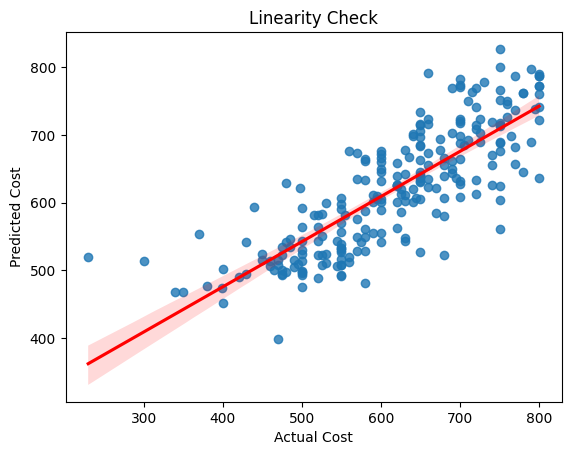

In [25]:
# Scatter plot for linearity check
# Get actual and predicted costs as Pandas DataFrames
actual_cost = test_data.select('cost').toPandas()
predictions = lr_model.transform(test_data).select('prediction').toPandas()

# Combine the actual and predicted costs into a single DataFrame
comparison_df = actual_cost.copy()
comparison_df['predicted'] = predictions['prediction']

# Scatter plot for linearity check
sns.regplot(x='cost', y='predicted', data=comparison_df, line_kws={"color": "red"})
plt.xlabel('Actual Cost')
plt.ylabel('Predicted Cost')
plt.title('Linearity Check')
plt.show()

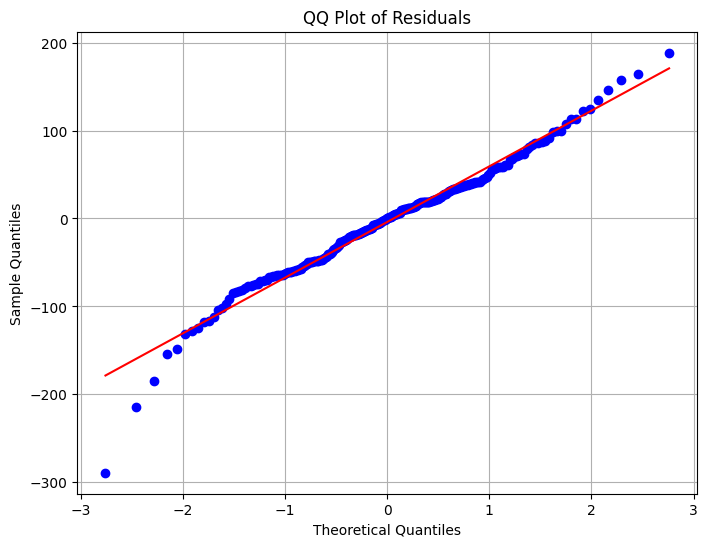

In [26]:
import scipy.stats as stats
# Step 1: Get actual and predicted costs
actual_cost = test_data.select('cost').toPandas()
predictions = lr_model.transform(test_data).select('prediction').toPandas()

# Step 2: Calculate residuals
residuals = actual_cost['cost'] - predictions['prediction']

# Step 3: Create a QQ plot
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')  
plt.grid()
plt.show()

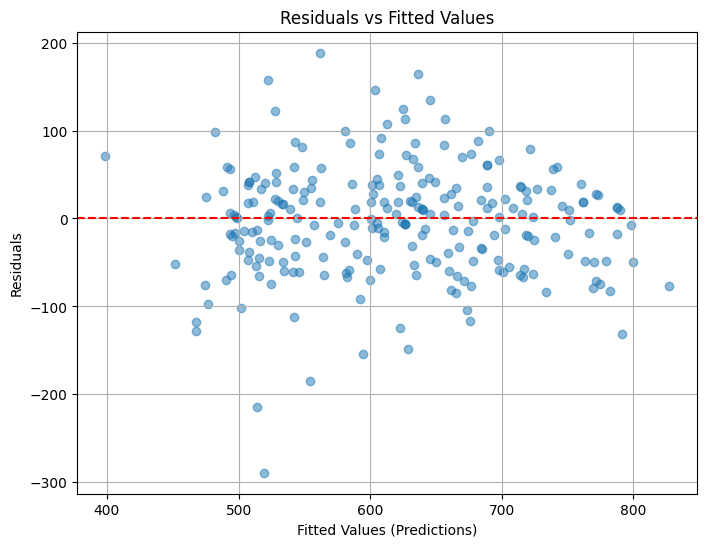

In [27]:
### Residuals vs fitted... 


actual_cost = test_data.select('cost').toPandas()
predictions = lr_model.transform(test_data).select('prediction').toPandas()

# Step 2: Calculate residuals
residuals = actual_cost['cost'] - predictions['prediction']

# Step 3: Create a Residuals vs. Fitted Values Plot
plt.figure(figsize=(8, 6))
plt.scatter(predictions['prediction'], residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values (Predictions)')
plt.ylabel('Residuals')
plt.grid()
plt.show()

## TREE MODELS

In [28]:
# Create a VectorAssembler to combine feature columns into a single vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Select the target variable (cost) and prepare the final DataFrame
data = sdf.select('cost', *feature_columns)

# Transform the features into a single vector column
data = assembler.transform(data)

# Create a MinMaxScaler instance
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')

# Fit the scaler to the data
scaler_model = scaler.fit(data)

# Transform the data using the fitted scaler
data = scaler_model.transform(data)

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1003)

In [29]:
# Initialize the Gradient Boosting model
gbt = GBTRegressor(featuresCol='scaled_features', labelCol='cost', maxIter=40)

# Fit the model to the training data
gbt_model = gbt.fit(train_data)

In [30]:
# Print model summary
print("Gradient Boosting Model Summary")
print("Number of Trees: ", gbt_model.getNumTrees)

# Evaluate the model on the test data
gbt_predictions = gbt_model.transform(test_data)

# Create evaluators for RMSE, MAE, and R-squared
rmse_evaluator = RegressionEvaluator(labelCol="cost", predictionCol="prediction", metricName="rmse")
mae_evaluator = RegressionEvaluator(labelCol="cost", predictionCol="prediction", metricName="mae")
r2_evaluator = RegressionEvaluator(labelCol="cost", predictionCol="prediction", metricName="r2")

# Evaluate the model on the test data
gbt_rmse = rmse_evaluator.evaluate(gbt_predictions)
gbt_mae = mae_evaluator.evaluate(gbt_predictions)
gbt_r2 = r2_evaluator.evaluate(gbt_predictions)

# Print evaluation metrics
print(f"Gradient Boosting Test RMSE: {gbt_rmse}, MAE: {gbt_mae}, R2: {gbt_r2}")

Gradient Boosting Model Summary
Number of Trees:  40
Gradient Boosting Test RMSE: 106.8661515969548, MAE: 64.85183424627928, R2: 0.572625188110983


In [31]:
# Get feature importances
gbt_feature_importances = gbt_model.featureImportances

# Create a DataFrame from the feature importances
feature_importances_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': gbt_feature_importances.toArray()
})

# Sort the DataFrame by the 'importance' column in decreasing order
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)
feature_importances_df

,feature,importance
1,beds,0.148149
2,baths,0.096887
4,built_in_wardrobes,0.060988
39,supermarkets_Average Travel Time (Mins),0.058243
59,normalized_livability_score,0.040370
47,shopping_districts_Average Travel Time (Mins),0.034017
52,train_stations_Average Travel Time (Mins),0.033076
36,schools_Average Travel Distance (Kms),0.032378
41,supermarkets_Time_Distance_Product,0.032331
46,shopping_districts_count,0.029934
